M54 data - Part 4
=================

First, we set up the data:

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
m54_data.logarithmically_resample(dv=50.)

ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



Let us make a function that brings the fitted distribution function in the correct orientation.

In [190]:
%matplotlib inline

def orient_image(f):
    """
    Transform the distribution function that goes into observation operator into an image
    that has the correct orientation for visualisation.
    """
    image = f
    # Have to flip.
    image = np.flipud(image)
    return image

Recreating the PPXF fit
-----------------------

Next, we fit the data using ``ppxf``

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.088     0.187
chi2/DOF: 0.9353; degree = -1; mdegree = 21
method = capfit; Jac calls: 9; Func calls: 241; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  22 / 636


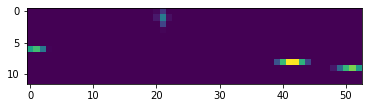

In [191]:
from ppxf import ppxf

npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=21,
    moments=moments,
    bounds=bounds,
    regul=1e-10,
    mask=mask
)

f_ppxf = np.reshape(ppxf_fit.weights, ssps.par_dims)
im_ppxf = orient_image(f_ppxf)
plt.imshow(im_ppxf)
plt.show()




Repeat fit, but with lower regularization.


 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.000    -0.012
chi2/DOF: 0.8946; degree = -1; mdegree = 21
method = capfit; Jac calls: 14; Func calls: 370; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 636


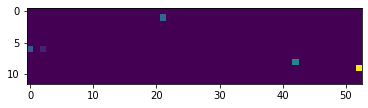

In [192]:
ppxf_fit2 = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=21,
    moments=moments,
    bounds=bounds,
    regul=1e-12,
    mask=mask
)

f_ppxf2 = np.reshape(ppxf_fit2.weights, ssps.par_dims)
im_ppxf2 = orient_image(f_ppxf2)
plt.imshow(im_ppxf2)
plt.show()


Next, we compute the MAP estimate from our Bayesian model:

First, correct the templates using the fitted polynomial.

In [193]:
continuum_distorition = ppxf_fit.mpoly
# add an extra element to the end of array to account for one that we chopped off earlier
continuum_distorition = np.concatenate([continuum_distorition, [continuum_distorition[-1]]])

import copy
ssps_corrected = copy.deepcopy(ssps)
ssps_corrected.Xw = (ssps_corrected.Xw.T * continuum_distorition).T

Adapt the observation operator:

In [194]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(ssps=ssps_corrected,
                        dv=ssps_corrected.dv,
                        do_log_resample=False)
G_orig = ObservationOperator(ssps=ssps, dv=ssps.dv, do_log_resample=False)

Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


We set $\theta_v$ equal to the PPXF fit. We have to invert the sign of $h_3$.

In [195]:
theta_v = np.array([146, 3, 1., 0., 0., 0.088, 0.187])

Rescale the data.

In [196]:
mask = m54_data.mask
y = m54_data.y[mask]
y_sd = m54_data.noise_level[mask]

ppxf_scale = np.linalg.norm(f_ppxf)
s = ppxf_scale
y_scaled = y / s
y_sd_scaled = y_sd / s

With this, lets compute the MAP estimate for $g = f / s$.

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 5571.298589693
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.536040052623116    |  4.294752487671305e-13  |    20.30109994079702    |           1.0           |    1.0443904399871826   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.5360400526231158   |  4.319052

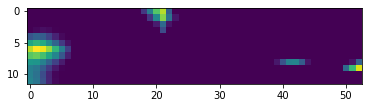

In [197]:
%matplotlib inline

from uq4pk_fit.inference import ForwardOperator, StatModel
from uq4pk_fit.special_operators import OrnsteinUhlenbeck, DiscreteGradient, DiscreteLaplacian


forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps_corrected, dv=ssps_corrected.dv,
                                   do_log_resample=False)
# Fit the model
model = StatModel(y=y_scaled, y_sd=y_sd_scaled, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.beta1 = 1.
model.P1 = OrnsteinUhlenbeck(m=model.m_f, n=model.n_f, h=np.array([2., 1.]))
fitted_model = model.fit()
g_map = fitted_model.f_map
f_map = s * g_map.clip(min=0.)  # Enforce nonnegativity

im_map = orient_image(f_map)
plt.imshow(im_map)

delta_zt = ssps.delta_z[:, np.newaxis] * ssps.delta_t[np.newaxis]
f_map_scaled = delta_zt * f_map

Finally, let us compare the images:

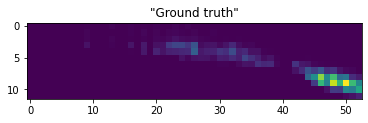

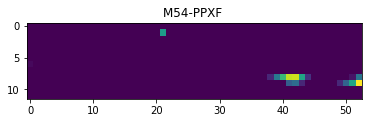

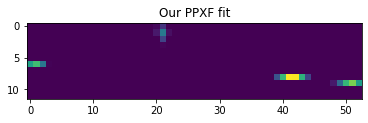

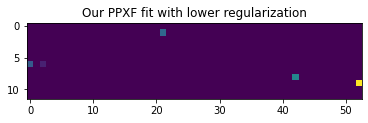

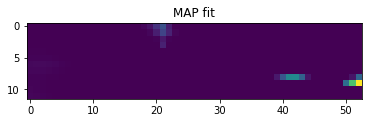

In [198]:
im_ppxf = orient_image(f_ppxf)
im_map = orient_image(f_map_scaled)

f_true = m54_data.ground_truth.T
im_true = orient_image(f_true)
plt.imshow(im_true)
plt.title('"Ground truth"')
plt.show()

f_ppxf_m54 = m54_data.ppxf_map_solution.T
im_ppxf_m54 = orient_image(f_ppxf_m54)
plt.imshow(im_ppxf_m54)
plt.title('M54-PPXF ')
plt.show()

plt.imshow(im_ppxf)
plt.title("Our PPXF fit")
plt.show()

plt.imshow(im_ppxf2)
plt.title("Our PPXF fit with lower regularization")
plt.show()

plt.imshow(im_map)
plt.title("MAP fit")
plt.show()

I wonder whether M54 shows the leftmost clump at all? Let us compare the thresholded images:


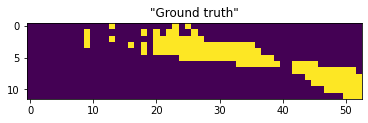

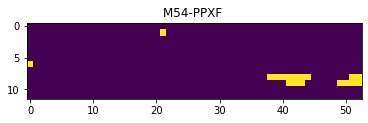

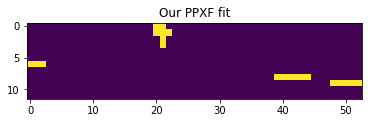

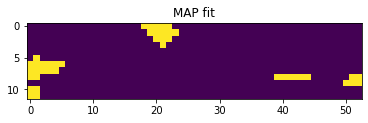

In [199]:
# Create helper function that computes the threshold-image.
def threshold_image(image, rthresh):
    # Absolute threshold = Relative threshold * image maximum
    athresh = rthresh * image.max()
    thresholded_image = (image > athresh)
    return thresholded_image

# Let's use 1% relative threshold
rthresh = 0.01

plt.imshow(threshold_image(im_true, rthresh))
plt.title('"Ground truth"')
plt.show()


plt.imshow(threshold_image(im_ppxf_m54, rthresh))
plt.title('M54-PPXF ')
plt.show()

plt.imshow(threshold_image(im_ppxf, rthresh))
plt.title("Our PPXF fit")
plt.show()

plt.imshow(threshold_image(im_map, rthresh))
plt.title("MAP fit")
plt.show()
